In [1]:
import tensorflow as tf
from tensorflow import keras    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


import dataset store from Data_preparation

In [2]:
train_path = './dataset/train'
valid_path = './dataset/val'
test_path = './dataset/test'

In [3]:
breeds = [
    "Holstein_cow", "Jersey_cow", "Angus_cow", "Brahman_cow", "Hereford_cow",
    "Simmental_cow", "Limousin_cow", "Guernsey_cow", "Charolais_cow", "Ayrshire_cow"
]

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=breeds, batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=breeds, batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=breeds, batch_size = 10, shuffle=False)


Found 2802 images belonging to 10 classes.
Found 1069 images belonging to 10 classes.
Found 1083 images belonging to 10 classes.


if use "==" below the number must be same as number of image found above

In [4]:
assert train_batches.n >= 1000
assert valid_batches.n >= 300
assert test_batches.n >= 150
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10
assert train_batches.batch_size == valid_batches.batch_size == test_batches.batch_size == 10
assert train_batches.class_indices == valid_batches.class_indices == test_batches.class_indices

# 1. CNN

# 1.1. Training the model

In [5]:
imgs , labels = next(train_batches)
print("Shape of the image batch: ", imgs.shape)
print("Shape of the label batch: ", labels.shape)

Shape of the image batch:  (10, 224, 224, 3)
Shape of the label batch:  (10, 10)


In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

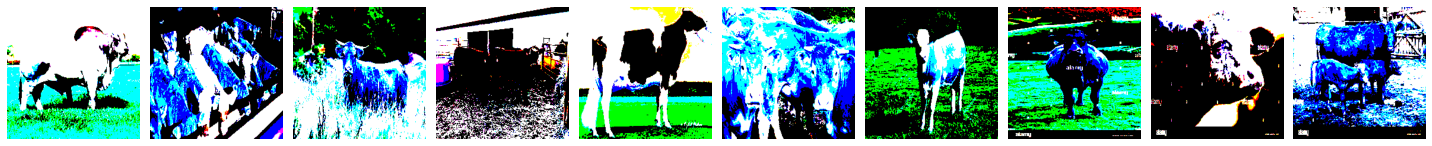

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [7]:
plotImages(imgs)
print(labels)

In [8]:
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same',input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=10, activation='softmax'),
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 10)                2007050   
Total params: 2,026,442
Trainable params: 2,026,442
Non-trainable params: 0
______________________________________________

In [10]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# 2.Model:ResNet50, DenseNet121, MobileNetV3Large


In [11]:
import time
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [12]:
def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    optimizer = Adam(learning_rate=0.001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# Helper function to calculate mAP
def mean_average_precision(y_true, y_pred):
    # y_true and y_pred should be numpy arrays
    # This is a simple implementation for multiclass, multi-label
    import sklearn.metrics
    return sklearn.metrics.average_precision_score(y_true, y_pred, average='macro')

input_shape = (224, 224, 3)
num_classes = len(breeds)
epochs = 50
results = {}

# ResNet50 

Training

In [ ]:
print("Training ResNet50...")
resnet50_model = build_model(ResNet50, input_shape, num_classes)
start_time = time.time()
history = resnet50_model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=epochs,
    verbose=1,
)
training_time = time.time() - start_time

Training ResNet50...
Epoch 1/50
 39/281 [===>..........................] - ETA: 27:07:36 - loss: 2.8620 - accuracy: 0.1974

Evaluate on validation set

In [ ]:
# Evaluate ResNet50 on validation set and store results for later use
val_imgs, val_labels = next(valid_batches)
val_preds = resnet50_model.predict(val_imgs)
acc = np.mean(np.argmax(val_preds, axis=1) == np.argmax(val_labels, axis=1))
mAP = mean_average_precision(val_labels, val_preds)
results['ResNet50'] = {
    'training_time_sec': training_time,
    'val_accuracy': acc,
    'val_mAP': mAP,
    'history': history,
    'val_imgs': val_imgs,
    'val_labels': val_labels,
    'val_preds': val_preds
}
# resnet50_model is now available for later use

In [ ]:
with open('results_resnet50.pkl', 'wb') as file:
    pickle.dump(results, file)

Display training time, accuracy, and mAP for all models separately

In [ ]:
for model_name, res in results.items():
    print(f"Model: {model_name}")
    print(f"  Training Time: {res['training_time_sec']:.2f} seconds")
    print(f"  Validation Accuracy: {res['val_accuracy']:.4f}")
    print(f"  Validation mAP: {res['val_mAP']:.4f}")
    print("-" * 40)

In [ ]:
resnet50_model.summary()
# Save the ResNet50 model


# DenseNet121

Training

In [ ]:
print("Training DenseNet121...")
densenet121_model = build_model(DenseNet121, input_shape, num_classes)
start_time = time.time()
history = densenet121_model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=epochs,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
training_time = time.time() - start_time

Training ResNet50...
Epoch 1/2
242/242 [==============================] - 418s 2s/step - loss: 2.4772 - accuracy: 0.2423 - val_loss: 12.0649 - val_accuracy: 0.1953
Epoch 2/2
242/242 [==============================] - 418s 2s/step - loss: 1.9539 - accuracy: 0.3384 - val_loss: 2.9821 - val_accuracy: 0.2247
Training DenseNet121...
29097984/29084464 [==============================] - 489s 17us/step
Epoch 1/2
242/242 [==============================] - 555s 2s/step - loss: 2.0567 - accuracy: 0.3281 - val_loss: 16.1362 - val_accuracy: 0.1263
Epoch 2/2
242/242 [==============================] - 546s 2s/step - loss: 1.6416 - accuracy: 0.4540 - val_loss: 2.9399 - val_accuracy: 0.2937
Training MobileNetV3Large...
17620992/17605208 [==============================] - 295s 17us/step
Epoch 1/2
242/242 [==============================] - 137s 548ms/step - loss: 1.4842 - accuracy: 0.5141 - val_loss: 4.0490 - val_accuracy: 0.2188
Epoch 2/2
242/242 [==============================] - 134s 553ms/step - loss

Evaluate

In [ ]:
val_imgs, val_labels = next(valid_batches)
val_preds = densenet121_model.predict(val_imgs)
acc = np.mean(np.argmax(val_preds, axis=1) == np.argmax(val_labels, axis=1))
mAP = mean_average_precision(val_labels, val_preds)
results['DenseNet121'] = {
    'training_time_sec': training_time,
    'val_accuracy': acc,
    'val_mAP': mAP,
    'history': history,
    'val_imgs': val_imgs,
    'val_labels': val_labels,
    'val_preds': val_preds
}

In [ ]:
with open('results_densenet121.pkl', 'wb') as file:
    pickle.dump(results, file)

Display training time, accuracy, and mAP for all models separately

In [ ]:
for model_name, res in results.items():
    print(f"Model: {model_name}")
    print(f"  Training Time: {res['training_time_sec']:.2f} seconds")
    print(f"  Validation Accuracy: {res['val_accuracy']:.4f}")
    print(f"  Validation mAP: {res['val_mAP']:.4f}")
    print("-" * 40)

# MobileNetV3Large

Training

In [ ]:

print("Training MobileNetV3Large...")
mobilenetv3_model = build_model(MobileNetV3Large, input_shape, num_classes)
start_time = time.time()
history = mobilenetv3_model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=epochs,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
training_time = time.time() - start_time



Evaluate

In [ ]:
val_imgs, val_labels = next(valid_batches)
val_preds = mobilenetv3_model.predict(val_imgs)
acc = np.mean(np.argmax(val_preds, axis=1) == np.argmax(val_labels, axis=1))
mAP = mean_average_precision(val_labels, val_preds)
results['MobileNetV3Large'] = {
    'training_time_sec': training_time,
    'val_accuracy': acc,
    'val_mAP': mAP,
    'history': history,
    'val_imgs': val_imgs,
    'val_labels': val_labels,
    'val_preds': val_preds
}

In [ ]:
with open('mobilenetv3_results.pkl', 'wb') as file:
    pickle.dump(results, file)

Display training time, accuracy, and mAP for all models separately

In [ ]:
for model_name, res in results.items():
    print(f"Model: {model_name}")
    print(f"  Training Time: {res['training_time_sec']:.2f} seconds")
    print(f"  Validation Accuracy: {res['val_accuracy']:.4f}")
    print(f"  Validation mAP: {res['val_mAP']:.4f}")
    print("-" * 40)

Model: MobileNetV3Large
  Training Time: 270.51 seconds
  Validation Accuracy: 0.1000
  Validation mAP: nan
----------------------------------------


d:\pylearn\GroupProject_1\ISB46703\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
d:\pylearn\GroupProject_1\ISB46703\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
d:\pylearn\GroupProject_1\ISB46703\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
d:\pylearn\GroupProject_1\ISB46703\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
